<a href="https://colab.research.google.com/github/mannb986/covid19_pneumonia_classification/blob/main/covid19_pneumonia_classification_deepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 and Pneumonia Classification with Deep Learning

The task here is to develop a learning model to support doctors with diagnosing illnesses that affect patients' lungs. I will use a set of data provided that is X-rays of lung scans with examples of patients who had either pneumonia, COVID-19, or no illness. 

Using Keras module, I will create a classification model that outputs a diagnosis based on a patient's X-ray scan. 

## Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer

import os
import numpy as np
import matplotlib.pyplot as plt

## Importing from Google Drive

The file is archived as a ZIP file in Google Drive (in the same folder as this Colab notebook). It is set as shared and the shared link used below.

Note the original folder structure:

* Train
  * Covid
  * Normal
  * Pneumonia

* Test
  * Covid
  * Normal
  * Pneumonia

Make sure that the sub-folders have exactly the same names (and cases, i.e. each sub-folder name starts with an uppercase letter).

The images were originally stored in the structure above inside a folder named classification-challenge. This folder was compressed as a ZIP file and uploaded to Google Drive.

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
fid = drive.ListFile({'q':"title='Covid19-dataset.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('Covid19-dataset.zip')

In [6]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [7]:
!unzip Covid19-dataset.zip

Archive:  Covid19-dataset.zip
   creating: Covid19-dataset/
  inflating: Covid19-dataset/.DS_Store  
   creating: Covid19-dataset/test/
  inflating: Covid19-dataset/test/.DS_Store  
   creating: Covid19-dataset/test/Pneumonia/
  inflating: Covid19-dataset/test/Pneumonia/59.png  
  inflating: Covid19-dataset/test/Pneumonia/14.png  
  inflating: Covid19-dataset/test/Pneumonia/29.png  
  inflating: Covid19-dataset/test/Pneumonia/12.png  
  inflating: Covid19-dataset/test/Pneumonia/21.png  
  inflating: Covid19-dataset/test/Pneumonia/20.png  
  inflating: Covid19-dataset/test/Pneumonia/27.png  
  inflating: Covid19-dataset/test/Pneumonia/33.png  
  inflating: Covid19-dataset/test/Pneumonia/18.png  
  inflating: Covid19-dataset/test/Pneumonia/31.png  
  inflating: Covid19-dataset/test/Pneumonia/19.png  
  inflating: Covid19-dataset/test/Pneumonia/43.png  
  inflating: Covid19-dataset/test/Pneumonia/54.png  
  inflating: Covid19-dataset/test/Pneumonia/6.png  
  inflating: Covid19-dataset/tes

In [8]:
PATH = '/content/Covid19-dataset'

In [9]:
os.listdir(PATH)

['.DS_Store', 'train', 'test']

In [10]:
train_dir = os.path.join(PATH,
                         'train')
test_dir = os.path.join(PATH,
                        'test')

In [11]:
train_covid_dir = os.path.join(train_dir,
                                'Covid')
train_normal_dir = os.path.join(train_dir,
                                   'Normal')
train_pneumonia_dir = os.path.join(train_dir,
                               'Pneumonia')

test_covid_dir = os.path.join(test_dir,
                               'Covid')
test_normal_dir = os.path.join(test_dir,
                                  'Normal')
test_pneumonia_dir = os.path.join(test_dir,
                              'Pneumonia')

In [12]:
len(os.listdir(train_covid_dir))

111

In [13]:
len(os.listdir(train_pneumonia_dir ))

70

In [14]:
len(os.listdir(train_normal_dir ))

70

## Preparing Data

In [15]:
IMG_HEIGHT = 212
IMG_WIDTH = 212
batch_size = 32

In [16]:
image_gen = ImageDataGenerator(
    rescale=1./255
    )

In [17]:
train_data_gen = image_gen.flow_from_directory(
    #batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical')

Found 251 images belonging to 3 classes.


In [18]:
test_data_gen = image_gen.flow_from_directory(
    #batch_size=batch_size,
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical')

Found 66 images belonging to 3 classes.


## Building Model

In [19]:
model = Sequential()

In [20]:
test_data_gen.image_shape

(212, 212, 3)

In [21]:
model.add(InputLayer(input_shape=(212, 212, 3)))
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
              )

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 212, 212, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 106, 106, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 106, 106, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 106, 106, 128)     36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       1

## Training the Model

In [24]:
batch_size = 32
epochs = 20

In [25]:
num_normal_train = len(os.listdir(train_normal_dir))
num_covid_train = len(os.listdir(train_covid_dir))
num_pneumonia_train = len(os.listdir(train_pneumonia_dir))

num_normal_test = len(os.listdir(test_normal_dir))
num_covid_test = len(os.listdir(test_covid_dir))
num_pneumonia_test = len(os.listdir(test_pneumonia_dir))

total_train = num_normal_train + num_covid_train + num_pneumonia_train
total_test = num_normal_test + num_covid_test + num_pneumonia_test

In [28]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=total_test // batch_size,
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=7
    )]
)

Epoch 1/20
7/7 [==============================] - 1s 164ms/step - loss: 0.0835 - categorical_accuracy: 0.9772 - auc: 0.9980 - val_loss: 0.7443 - val_categorical_accuracy: 0.8438 - val_auc: 0.9405
Epoch 2/20
7/7 [==============================] - 1s 141ms/step - loss: 1.8295 - categorical_accuracy: 0.8995 - auc: 0.9386 - val_loss: 1.5272 - val_categorical_accuracy: 0.6875 - val_auc: 0.8670
Epoch 3/20
7/7 [==============================] - 1s 145ms/step - loss: 1.3239 - categorical_accuracy: 0.8128 - auc: 0.9177 - val_loss: 0.5870 - val_categorical_accuracy: 0.8594 - val_auc: 0.9473
Epoch 4/20
7/7 [==============================] - 1s 140ms/step - loss: 0.2066 - categorical_accuracy: 0.9269 - auc: 0.9909 - val_loss: 0.9789 - val_categorical_accuracy: 0.7812 - val_auc: 0.8855
Epoch 5/20
7/7 [==============================] - 1s 139ms/step - loss: 0.2936 - categorical_accuracy: 0.9406 - auc: 0.9760 - val_loss: 1.1974 - val_categorical_accuracy: 0.7188 - val_auc: 0.8575
Epoch 6/20
7/7 [====

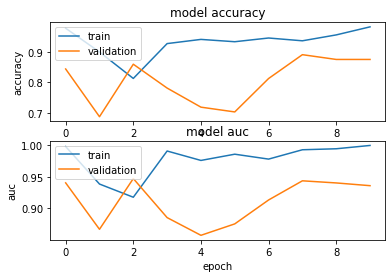

In [30]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['categorical_accuracy'])
ax1.plot(history.history['val_categorical_accuracy'])
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend(['train', 'validation'], loc='upper left')


# plotting auc and validation auc over epochs
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['auc'])
ax2.plot(history.history['val_auc'])
ax2.set_title('model auc')
ax2.set_xlabel('epoch')
ax2.set_ylabel('auc')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

## Results

The model resulted in a accuracy of of over 87% with the validation data. 